In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

# Please set a proper path to where the modules below are located.
# For example: 
# %cd [USER PATH]

from vmgp import vmgp
from _data_.genData import genData, genMissing, cen_to_fed
from GPtools.optimizer import adam
from GPtools.genBatch import genBatch
from GPtools.stepsize import block_const
from FL import agg_weights, aggregate_param, optimize

In [2]:
############ Settings ############

# General
SEED = 3
VERBOSE = True
PRINT_EVERY = 5

# Data generation
NOUT = 5
N = 500
Nobs = 200

# Client
N_INDUCING = 30
BATCH_SIZE = 50

# FedMGP
COMM = 300; CUT_POINTS=[70, 180]; STEP_SIZES=[0.1, 0.01, 0.001]
LOCAL_STEPS = 20
C = 1

Seed is set to 3


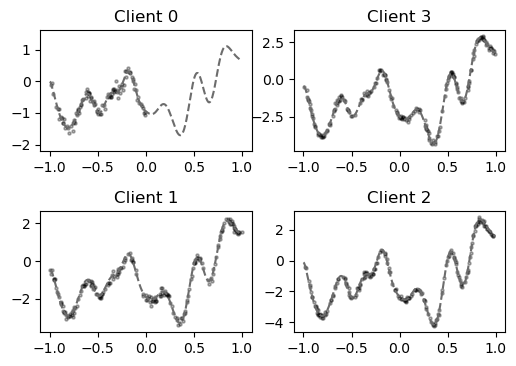

In [3]:
############ Synthetic data generation ############

# Generate data
data = genData('convolution', seedVal=SEED, nout=NOUT,
        param_u=(0.1, 1), param_flen=(2, 10), param_fvar=(.5, 3.), noise=0.1,
        N=N
)

# make a missing range
bdata = genMissing(bdata=data, Nobs=Nobs, missing_range=(0, 1), 
    missingUnit=[0], diffX=False
)

# make federated
data = cen_to_fed(bdata=bdata)

# plot data
num_display = 4; ncols = 2
fig, ax = plt.subplots(
    nrows=int(num_display/ncols), ncols=ncols, facecolor='white', dpi=100,
    figsize= (6,4)
)
plt.subplots_adjust(hspace = 0.5)

ax = ax.flatten()
if NOUT > num_display:
    displayIdx = npr.choice(
        np.arange(1, NOUT), size=num_display, replace=False
    ); displayIdx[0] = 0
else: displayIdx = np.arange(NOUT)


for i, idx in enumerate(displayIdx):
    ax[i].set_title('Client {}'.format(idx))
    ax[i].set_xlim([-1.1, 1.1])
    ax[i].set_ylim([
        np.min(bdata['true']['ytrue'][idx])-.5, 
        np.max(bdata['true']['ytrue'][idx])+.5
    ])
    ax[i].plot(bdata['true']['X'][idx], bdata['true']['ytrue'][idx],
        c='#6C6C6C', linestyle='--')
    ax[i].scatter(bdata['X'][idx], bdata['y'][idx], 
        s=5, c='black', alpha=0.3, marker='o'
    )

In [4]:
########## Create Clients Class ###########

# Clients
clients = {i_out: vmgp(X=data[i_out]['X'], y=data[i_out]['y'], 
    nlf=1, fixInducing=True, numInducing=N_INDUCING, optMean=False, 
    addIndKern=False, xrange=(-1,1), nfed=NOUT
    ) for i_out in range(NOUT)
}

# Batch generator 
batch_generators = {
    i_out: genBatch(
        batch_size=BATCH_SIZE, nobs=clients[i_out].nobs, 
        batch_assign='prop', count_iter=True, batch_type='permutation'
    ) for i_out in range(NOUT)
}

# Preprocess each client
for i_client, client in clients.items():
    optimize(
        client=client, lr=0.1, verbose=False,
        num_iters=500, batch_generator=batch_generators[i_client]
    )

# Specificy param idx to be aggregated
start_idx = 0; 
tmp_list = ['pre diff f', 'sen diff f']
for paramName in tmp_list:
    start_idx += clients[0].param[paramName].shape[0]
end_idx = start_idx
tmp_list = ['pre RBF u', 'var RBF u', 'mean vardist u', 'cov vardist u']
for paramName in tmp_list:
    end_idx += clients[0].param[paramName].shape[0]
idx_aggregation = np.arange(start_idx, end_idx)

 c:\Users\seokhc\OneDrive - Umich\University of Michigan\1. UM_research\Research\7. federated MGP\code_r2\GPtools\utils.py:39: RuntimeWarning:invalid value encountered in log
 c:\Users\seokhc\OneDrive - Umich\University of Michigan\1. UM_research\Research\7. federated MGP\code_r2\GPtools\utils.py:39: RuntimeWarning:divide by zero encountered in log


In [5]:
######## Federated analytics by FedMGP #######

for i_comm in range(COMM):

    # Select clients
    idx_aclients = npr.choice(
        np.array(list(clients)),
        size=int(np.ceil((NOUT)*C)), replace=False
    )
    available_clients = {idx: clients[idx] for idx in idx_aclients}

    # Each client takes local steps
    lr = block_const(iteration=i_comm, cut_points=CUT_POINTS, step_sizes=STEP_SIZES)

    H_clients = dict()
    for i_client, client in available_clients.items():
        
        # get the current parameters
        H_client = client.get_param()
        
        # execute local step
        H_local_updated, _ = adam(
            x=H_client, func=client.ELBO, grad=client.gradELBO, 
            num_iters=LOCAL_STEPS, step_size=lr, verbose=False, 
            batch_generator=batch_generators[i_client]
        )
        H_clients[i_client] = H_local_updated
        
    # Update global parameters
    weights = agg_weights(clients=available_clients)
    
    H_aggregated, idx_aggregation = aggregate_param(
        H_clients, aggregate=idx_aggregation, 
        aggType='average', weights=weights
    )
    
    # Deploy updated global parameters
    f_clients = dict()
    for i_client, client in clients.items():
        H_client = client.get_param()
        H_client[idx_aggregation] = H_aggregated
        f_clients[i_client] = client.ELBO(H=H_client)
        ## -> Note that ELBO func includes model update.           
        

    # Report status
    if VERBOSE and (i_comm % PRINT_EVERY == 0):
        print(
            "Round: {} | lr: {} | avg obj: {:.3f} ".format(
                i_comm, lr, np.mean(list(f_clients.values()))
            )
        )

Round: 0 | lr: 0.1 | avg obj: 741.408 
Round: 5 | lr: 0.1 | avg obj: 109.146 
Round: 10 | lr: 0.1 | avg obj: 619.750 
Round: 15 | lr: 0.1 | avg obj: 297.775 
Round: 20 | lr: 0.1 | avg obj: 213.016 
Round: 25 | lr: 0.1 | avg obj: 690.569 
Round: 30 | lr: 0.1 | avg obj: 294.791 
Round: 35 | lr: 0.1 | avg obj: 236.421 
Round: 40 | lr: 0.1 | avg obj: 213.335 
Round: 45 | lr: 0.1 | avg obj: 551.338 
Round: 50 | lr: 0.1 | avg obj: 336.921 
Round: 55 | lr: 0.1 | avg obj: 497.835 
Round: 60 | lr: 0.1 | avg obj: 515.154 
Round: 65 | lr: 0.1 | avg obj: 311.816 
Round: 70 | lr: 0.01 | avg obj: 51.885 
Round: 75 | lr: 0.01 | avg obj: -344.527 
Round: 80 | lr: 0.01 | avg obj: -446.399 
Round: 85 | lr: 0.01 | avg obj: -475.816 
Round: 90 | lr: 0.01 | avg obj: -464.496 
Round: 95 | lr: 0.01 | avg obj: -452.836 
Round: 100 | lr: 0.01 | avg obj: -441.911 
Round: 105 | lr: 0.01 | avg obj: -431.048 
Round: 110 | lr: 0.01 | avg obj: -420.597 
Round: 115 | lr: 0.01 | avg obj: -409.888 
Round: 120 | lr: 0.0

In [6]:
######## prediction at new locations ########

Xpred = np.arange(-1.1, 1.1, step=0.01)[:, None]

ypred_mean, ypred_var = dict(), dict()
for i_client, client in clients.items():
    ypred_mean[i_client], ypred_var[i_client] = client.predict(Xpred=Xpred, i_out=0)

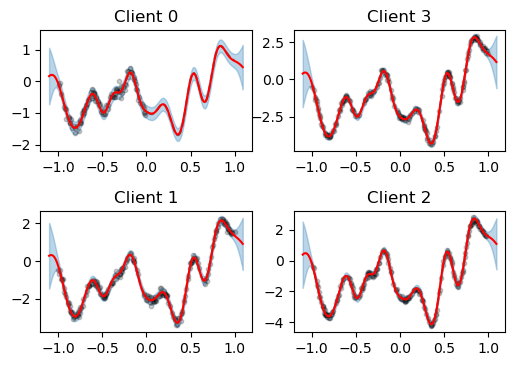

In [7]:
######## plot results ########

fig, ax = plt.subplots(
    nrows=int(num_display/ncols), ncols=ncols, facecolor='white', dpi=100,
    figsize = (6,4)
)
plt.subplots_adjust(hspace = 0.5)
ax = ax.flatten()

for i, idx in enumerate(displayIdx):
    ax[i].set_title('Client {}'.format(idx))
    ax[i].set_xlim([np.min(Xpred)-.1, np.max(Xpred)+.1])
    ax[i].set_ylim([
        np.min(bdata['true']['ytrue'][idx])-.5, 
        np.max(bdata['true']['ytrue'][idx])+.5
    ])

    ax[i].fill_between(
        Xpred.flatten(), 
        (ypred_mean[idx] - 1.96 * ypred_var[idx]**.5).flatten(),
        (ypred_mean[idx] + 1.96 * ypred_var[idx]**.5).flatten(),
        color='#1f77b4',
        alpha=0.3,
    )
    ax[i].plot(bdata['true']['X'][idx], bdata['true']['ytrue'][idx], 
        c='#6C6C6C', linestyle='--')
    ax[i].plot(Xpred, ypred_mean[idx], c='red')
    ax[i].scatter(bdata['X'][idx], bdata['y'][idx], 
        s=10, c='black', alpha=0.2
    )


In [36]:
######## uncertainty quantification ########
data = genData('convolution', seedVal=SEED, nout=NOUT,
        param_u=(0.1, 1), param_flen=(2, 10), param_fvar=(.5, 3.), noise=0.1,
        N=N
)

i_client = 0
ytrue = data['ytrue'][i_client][250:,:]
Xpred = data['X'][i_client][250:,:]

ypred_mean, ypred_var = dict(), dict()
ypred_mean[i_client], ypred_var[i_client] = clients[i_client].predict(Xpred=Xpred, i_out=0)

upper = ypred_mean[i_client] + 2.56 * ypred_var[i_client]**.5
lower = ypred_mean[i_client] - 2.56 * ypred_var[i_client]**.5

nsample = 200
nbetween = np.zeros(250)
for _ in range(nsample):
    sample = ytrue[:,0] + 0.1 * np.random.multivariate_normal(mean=np.zeros(250), cov=np.eye(250))
    nbetween += (sample < upper[:,0]) * (sample > lower[:,0])

print('UQ: {} % of observations are within the prediction intervals.'.format((nbetween/nsample).mean()*100))

Seed is set to 3
UQ: 99.148 % of observations are within the prediction intervals.
